In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


libraries Needed****

In [2]:
import numpy as np # linear algebra
import pandas as pd # for data analysis
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Load the datasets
path = '/kaggle/input/digit-recognizer/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path +'test.csv')

**Saparation of Label from the training set**

In [4]:
labels = train['label']
train.drop(['label'], axis= 1,  inplace = True)


In [5]:
#labels = tf.keras.utils.to_categorical(labels, num_classes = 10)


**Split the data in train and validation** set

In [6]:
split = int(int(train.size/784)*0.99) 
train_set = train[0:split]
val_set   = train[split:]
train_label = labels[0:split]
val_label   = labels[split:]

**Changing the shape of test set and normalization of test set**

In [7]:
test_set = np.array(test.values).reshape(-1, 28, 28)
test_input = tf.image.per_image_standardization(test_set)



**Data reshapping and normalization of train and validation set of data** 

In [8]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  #reshaping the train and validation set
  training_images = np.array(training_images.values).reshape(-1, 28, 28)
  validation_images = np.array(validation_images.values).reshape(-1, 28, 28)
  training_images = np.expand_dims(training_images,axis = -1)
  validation_images =np.expand_dims(validation_images, axis =-1)
    # Normalization of train and validation set 
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                    rotation_range=10,  
                                    zoom_range = 0.1)
    # setting the batch size to 32
  train_generator = train_datagen.flow(x=training_images, y=training_labels, batch_size=32)

  validation_datagen = ImageDataGenerator(rescale = 1./255)

  validation_generator = validation_datagen.flow(x=validation_images, y=validation_labels, batch_size=32)

  return train_generator, validation_generator

Data reshapping and normalization

In [9]:
train_input, val_input = train_val_generators(train_set, train_label, val_set, val_label)

# Model Design
2 convolutional layer following MaxPooling with Flatten and Desence Layer
Softmax is being used

In [10]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 28x28 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (5,5), activation='relu',padding = 'Same', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The 3rd convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

# Model Compilation
Adam is being used as an optimizer and Sparse Categorical Cross entropy as a loss function as it has more then 2 outputs

In [11]:
model.compile(optimizer = 'Adam',
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Model Training 
finally training with cross validation set

In [12]:
history = model.fit(train_input, epochs=10,validation_data=val_input)


Epoch 1/10
1300/1300 [==============================] - 31s 23ms/step - loss: 0.1894 - accuracy: 0.9395 - val_loss: 0.0625 - val_accuracy: 0.9810
Epoch 2/10
1300/1300 [==============================] - 29s 22ms/step - loss: 0.0639 - accuracy: 0.9801 - val_loss: 0.0283 - val_accuracy: 0.9929
Epoch 3/10
1300/1300 [==============================] - 30s 23ms/step - loss: 0.0444 - accuracy: 0.9873 - val_loss: 0.0215 - val_accuracy: 0.9952
Epoch 4/10
1300/1300 [==============================] - 29s 22ms/step - loss: 0.0419 - accuracy: 0.9874 - val_loss: 0.0384 - val_accuracy: 0.9929
Epoch 5/10
1300/1300 [==============================] - 30s 23ms/step - loss: 0.0351 - accuracy: 0.9895 - val_loss: 0.0745 - val_accuracy: 0.9905
Epoch 6/10
1300/1300 [==============================] - 29s 23ms/step - loss: 0.0295 - accuracy: 0.9909 - val_loss: 0.0463 - val_accuracy: 0.9905
Epoch 7/10
1300/1300 [==============================] - 29s 22ms/step - loss: 0.0287 - accuracy: 0.9912 - val_loss: 0.0237 -

# Plot accuracy , loss:

Plot the chart for accuracy and loss on both training and validation


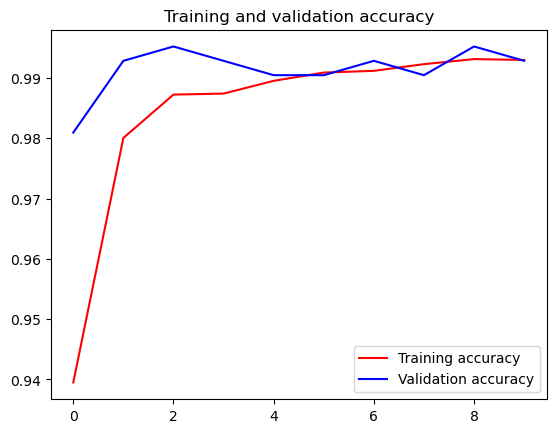

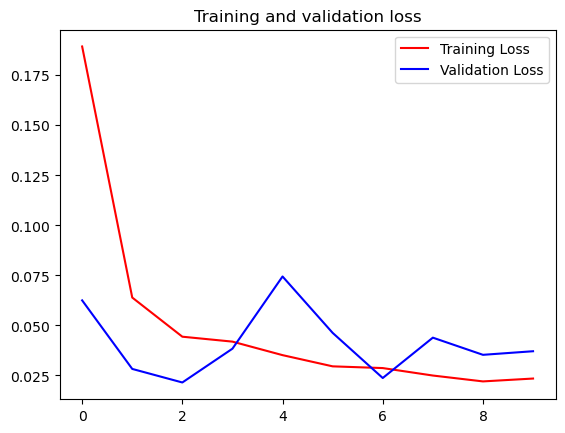

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Prediction
Prediction of Test data 

In [14]:
prediction = model.predict(test_input)

875/875 [==============================] - 7s 7ms/step


# Plot
show the first 10 samples of the images 

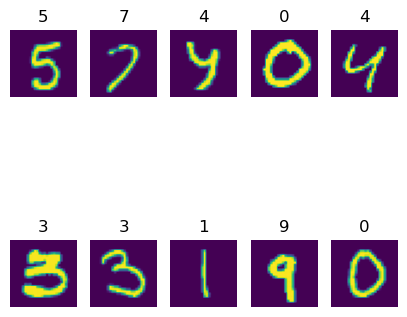

In [15]:
figure, axes = plt.subplots(2, 5, figsize=(5, 5))
axes = axes.ravel()

for index in range(0,10):
    axes[index].imshow(test_input[index+10])
    axes[index].set_title(np.argmax(prediction[index+10]))
    axes[index].axis("off")

In [16]:
predicted_labels = np.argmax(prediction, axis=1)
data_df = {'Label': predicted_labels}
solution = pd.DataFrame(data=data_df, index=pd.RangeIndex(start=1, stop=len(test)+1, name='ImageId'))
solution.to_csv('submission.csv')
